In [1]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker
import datetime
from dateutil.relativedelta import relativedelta
from jugaad_data.nse import index_raw

%matplotlib inline

### Data pull function

In [2]:
def fetch_index_data(index, start_date='1-1-2019', end_date='31-12-2023'):
    
    def convert_to_date(date_str):
        date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
        return date_obj

    # Get from and to dates
    from_date = datetime.datetime.strptime(start_date, '%d-%m-%Y').date()
    to_date = datetime.datetime.strptime(end_date, '%d-%m-%Y').date()
    
    # Pull data
    raw_index_data = index_raw(symbol=index, from_date=from_date, to_date=to_date)
    df = (pd.DataFrame(raw_index_data)\
            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
                    CLOSE=lambda x: x['CLOSE'].astype(float),
                    INDEX_NAME = lambda x: x['INDEX_NAME'].str.upper())\
            .sort_values('HistoricalDate')\
            .drop_duplicates()\
            .loc[lambda x: x['INDEX_NAME'] == index]\
            .reset_index(drop=True)\
            .rename(columns={'HistoricalDate':'date'})
                       )
    df = df.loc[~df.duplicated(subset=['date'], keep='first')]
    return df


### Function to calculate cumulative returns and growth

In [3]:
def get_cumulative_returns(df, 
                         nav_col='CLOSE', 
                         date_col='date',
                         starting_date='1-1-2019', 
                         ending_date ='31-12-2023'):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')
    
    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )
    
    return df

In [4]:
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200"]
nifty_indices_df_dict = {index: fetch_index_data(index) for index in nifty_indices}

### Data Pull

In [5]:
time_periods = {
    1: '1-1-2023', 
    2: '1-1-2022', 
    3: '1-1-2021',
    4: '1-1-2020',
    5: '1-1-2019',
}
results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((index_with_cumulative['CLOSE'].iloc[-1]/index_with_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][index] = index_with_cumulative
        results += [(index, time_period, absolute_returns_prcnt, cagr)]

NIFTY 500
NIFTY 50
NIFTY MIDCAP 150
NIFTY SMALLCAP 250
NIFTY 200


In [6]:
result_df = pd.DataFrame(results, columns=['Index', 'Years', 'Abs_returns_prcnt', 'CAGR']).\
pivot(index='Index', columns='Years', values=['Abs_returns_prcnt', 'CAGR'])
result_df.columns = [f'{x}_{y}' for x, y in result_df.columns]
result_df = result_df.applymap(lambda x: f"{x:.2f}%")
result_df

,Abs_returns_prcnt_1,Abs_returns_prcnt_2,Abs_returns_prcnt_3,Abs_returns_prcnt_4,Abs_returns_prcnt_5,CAGR_1,CAGR_2,CAGR_3,CAGR_4,CAGR_5
Index,,,,,,,,,,
NIFTY 200,22.91%,26.22%,62.45%,88.43%,104.35%,22.91%,12.35%,17.55%,17.16%,15.37%
NIFTY 50,19.42%,23.29%,55.02%,78.38%,99.19%,19.42%,11.04%,15.73%,15.57%,14.78%
NIFTY 500,25.16%,27.78%,67.86%,96.48%,111.23%,25.16%,13.04%,18.84%,18.39%,16.13%
NIFTY MIDCAP 150,42.66%,46.29%,114.72%,169.19%,169.28%,42.66%,20.95%,29.01%,28.09%,21.91%
NIFTY SMALLCAP 250,46.99%,40.89%,128.46%,186.98%,164.22%,46.99%,18.70%,31.70%,30.16%,21.45%


### Visualizations

[]

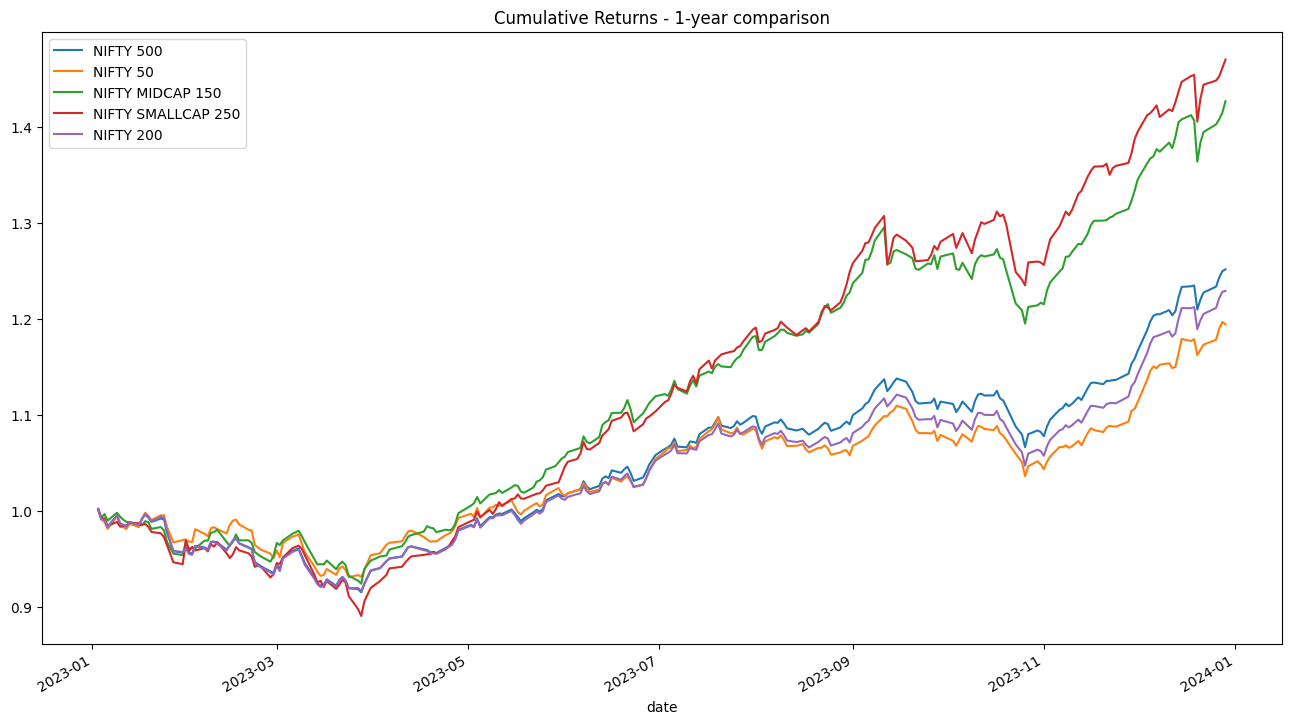

In [7]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 1

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()

[]

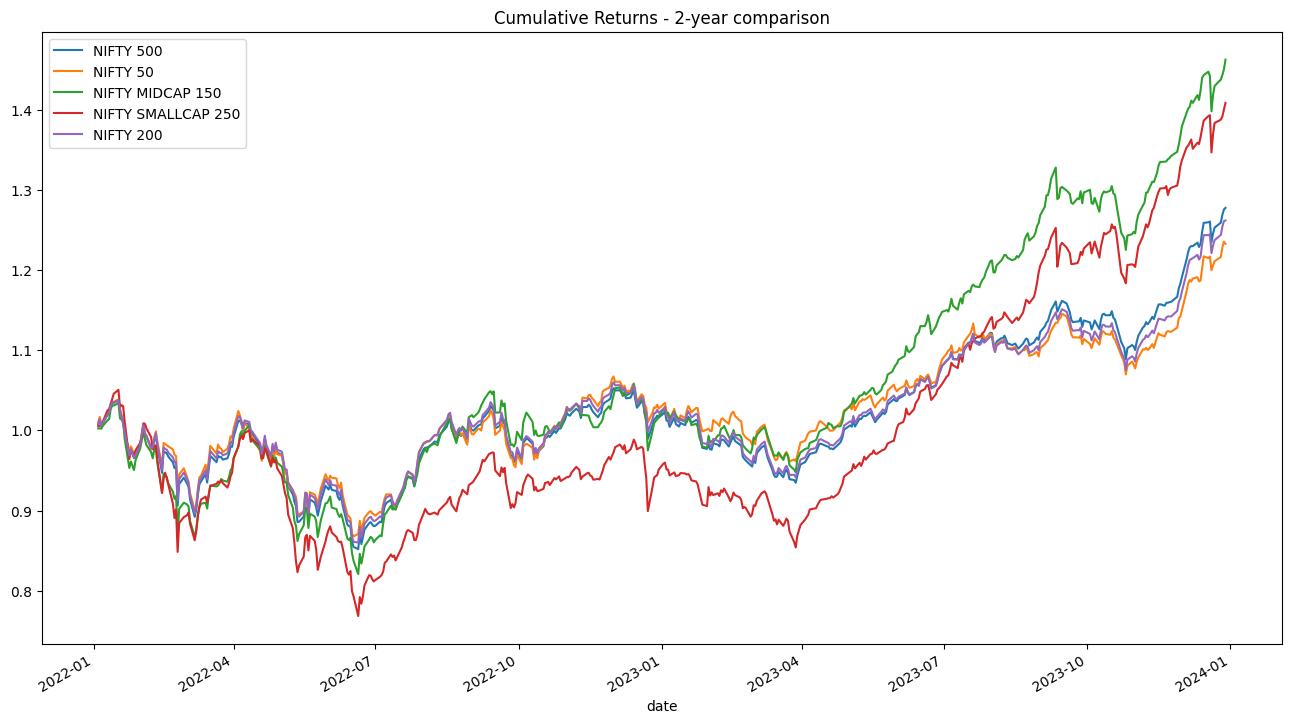

In [8]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 2

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()

[]

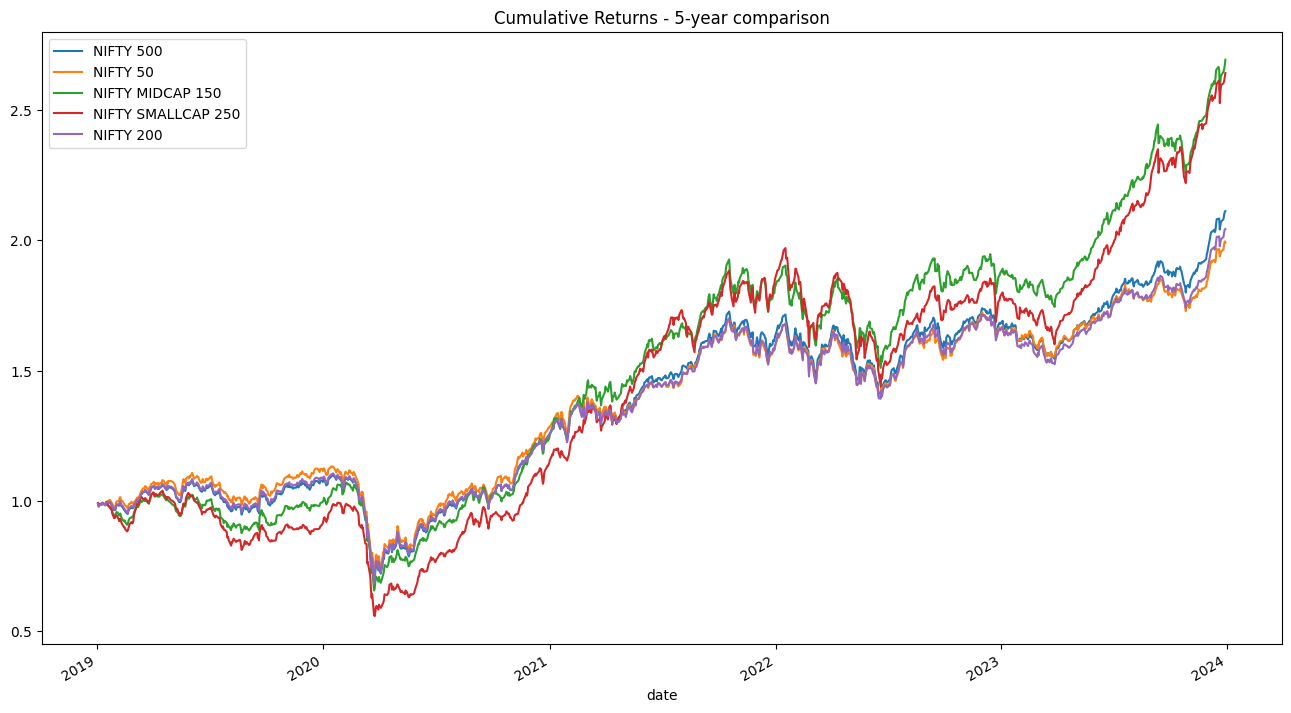

In [9]:
plt.rcParams["figure.figsize"] = [16,9]
time_period = 5

for idx, (instrument_desc, instrument_data) in enumerate(time_period_dataframes[time_period].items()):
    if idx == 0:
        ax = instrument_data.plot(y='cumulative_daily_returns', x='date', label=instrument_desc)
    else:
        instrument_data.plot(ax = ax, y='cumulative_daily_returns', x='date', label=instrument_desc)

plt.title(f"Cumulative Returns - {time_period}-year comparison")
ax.legend(loc='upper left')
plt.plot()

### Findings

1. While it is interesting to note that mid-cap and small-cap have comfortably given higher returns in the 5yrs window, that wasn't the trend before 2021. Small and midcap indices were lagging before 2021 and Nifty 50 was leading. This is the most interesting insight of the analysis
2. 1 year returns definitely point towards small-cap outperformance 
3. However, in the 5-years span, mid-cap has a slight edge over small-cap index. 
4. Nifty 500 is above Nifty 50 and Nifty 200 propelled by the tremendous performance of midcap and smallcap. 
5. The volatility of smallcap is clearly understood by comparing 1yr, 2yr, and 5 yr graphs

